The goal here is to augment our data by randomly replacing annotated words with synonyms.
Note that this is going to be dangerous for short annotations as we may replace the crucial part of the annotation!
It would be worth first collection information about annotation lengths:

Text(0.5, 1.0, 'Distribution of annotation lengths')

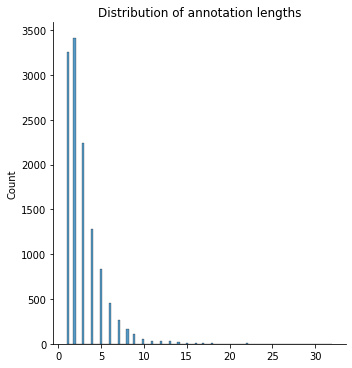

In [1]:
from project.data.data_loaders import get_clean_train_data
import seaborn as sns
import matplotlib.pyplot as plt
data = get_clean_train_data()
lengths = []
for idx, row in data.iterrows():
    for annotation in row['annotation']:
        lengths.append(len(annotation.split(' ')))
sns.displot(lengths)
plt.title('Distribution of annotation lengths')

In [2]:
data

,id,case_num,pn_num,feature_num,annotation,location_raw,feature_text,pn_history,location
0,00016_000,0,16,0,[dad with recent heart attcak],[696 724],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(696, 724)]"
1,00016_001,0,16,1,"[mom with ""thyroid disease]",[668 693],Family-history-of-thyroid-disorder,HPI: 17yo M presents with palpitations. Patien...,"[(668, 693)]"
2,00016_002,0,16,2,[chest pressure],[203 217],Chest-pressure,HPI: 17yo M presents with palpitations. Patien...,"[(203, 217)]"
3,00016_003,0,16,3,"[intermittent episodes, episode]","[70 91, 176 183]",Intermittent-symptoms,HPI: 17yo M presents with palpitations. Patien...,"[(70, 91), (176, 183)]"
4,00016_004,0,16,4,[felt as if he were going to pass out],[222 258],Lightheaded,HPI: 17yo M presents with palpitations. Patien...,"[(222, 258)]"
...,...,...,...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[],Family-history-of-migraines,Stephanie madden is a 20 year old woman compla...,[]
14296,95333_913,9,95333,913,[],[],Female,Stephanie madden is a 20 year old woman compla...,[]
14297,95333_914,9,95333,914,[photobia],[274 282],Photophobia,Stephanie madden is a 20 year old woman compla...,"[(274, 282)]"
14298,95333_915,9,95333,915,[no sick contacts],[421 437],No-known-illness-contacts,Stephanie madden is a 20 year old woman compla...,"[(421, 437)]"


Since the annotations are very specific to the data and pretty tight as bounding boxes, it may be better instead to just replace random words in the text **excluding** the annotated portion. 

In [3]:
from nltk.corpus import wordnet as wn
def get_synonyms(word):
    """Get the synonyms of word from Wordnet."""
    lemmas = set().union(*[s.lemmas() for s in wn.synsets(word)])
    return list(set(l.name().lower().replace("_", " ") for l in lemmas) - {word})
get_synonyms('computer')

['data processor',
 'information processing system',
 'reckoner',
 'computing machine',
 'estimator',
 'figurer',
 'calculator',
 'computing device',
 'electronic computer']

In [5]:
import random
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
def randomly_replace_token(r: pd.Series):
    tokens = [token for token in nlp(r['pn_history']) if token.is_alpha]
    def overlaps_with_annotation(token): 
        """Check if a token overlaps with a label."""
        for (s, e) in r['location']:
            if s <= token.idx < e:
                return True
        return False
    tokens = [token for token in tokens if not overlaps_with_annotation(token) and len(get_synonyms(token.text)) > 0]
    to_replace = random.choice(tokens)
    replacement_synonym = random.choice(get_synonyms(to_replace.text))
    new_text = r['pn_history'][:to_replace.idx] + replacement_synonym + r['pn_history'][to_replace.idx + len(to_replace.text):]
    new_loc = [(s, e) if s < to_replace.idx else (s + len(replacement_synonym) - len(to_replace.text), e + len(replacement_synonym) - len(to_replace.text)) for (s, e) in r['location'] ]
    return new_text, new_loc

In [8]:
from tqdm import tqdm
from joblib import Parallel, delayed
def produce_new_rows(r: pd.Series):
    replacements = []
    for _ in range(5):
        new_text, new_loc = randomly_replace_token(r)
        new_row = r.copy()
        new_row['pn_history'] = new_text
        new_row['location'] = new_loc
        replacements.append(new_row)
    return replacements
new_dataset = [produce_new_rows(r) for _, r in tqdm(data.iterrows(), total=len(data))]

100%|██████████| 14300/14300 [27:37<00:00,  8.63it/s]


In [11]:
from functools import reduce
new_dataset = list(reduce(lambda x, y: x + y, new_dataset))

In [16]:
pd.DataFrame(new_dataset).append(data).to_csv('/Users/evanvogelbaum/nbme_comp/src/project/data/train_data_with_synonyms.csv')

In [1]:
from project.data.data_loaders import get_synonym_training_data

In [2]:
data = get_synonym_training_data()

In [3]:
data

,Unnamed: 0,id,case_num,pn_num,feature_num,annotation,location_raw,feature_text,pn_history,location
0,0,00016_000,0,16,0,[dad with recent heart attcak],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(703, 731)]"
1,0,00016_000,0,16,0,[dad with recent heart attcak],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(696, 724)]"
2,0,00016_000,0,16,0,[dad with recent heart attcak],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(700, 728)]"
3,0,00016_000,0,16,0,[dad with recent heart attcak],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M presents with palpitations. Patien...,"[(696, 724)]"
4,0,00016_000,0,16,0,[dad with recent heart attcak],['696 724'],Family-history-of-MI-OR-Family-history-of-myoc...,HPI: 17yo M salute with palpitations. Patient ...,"[(694, 722)]"
...,...,...,...,...,...,...,...,...,...,...
85795,14295,95333_912,9,95333,912,[],[],Family-history-of-migraines,Stephanie madden is a 20 year old woman compla...,[]
85796,14296,95333_913,9,95333,913,[],[],Female,Stephanie madden is a 20 year old woman compla...,[]
85797,14297,95333_914,9,95333,914,[photobia],['274 282'],Photophobia,Stephanie madden is a 20 year old woman compla...,"[(274, 282)]"
85798,14298,95333_915,9,95333,915,[no sick contacts],['421 437'],No-known-illness-contacts,Stephanie madden is a 20 year old woman compla...,"[(421, 437)]"


In [4]:
data.iloc[0]['location']

[(703, 731)]